## Question Example

To run this example, don't forget to set your `OPEN_API_KEY` on your `.env` file

In [1]:
from IPython.display import Image, display
from annotated_types import Annotated

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.types import Command
from langgraph.prebuilt import InjectedState
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage


from assistant_core.builder import BuilderContext, SingleAgent
from assistant_core.builder.question import QuestionBuilder, ProcessAnswerNode
from assistant_core.factories import BaseAgentFactory
from assistant_core.nodes import AgentNode
from assistant_core.state import NextProcessState, QuestionState

In [2]:
ASSISTANT_PROMPT = """
You are a helpful assistant.
"""

In [3]:
config = {"configurable": {"thread_id": "test"}}

In [4]:
class ExampleState(NextProcessState):
    name: str | None = None


@tool
def verify_user_information(
    state: Annotated[dict, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> ExampleState:
    """Verify user's information."""

    if state.get("name") is None:
        return Command(
            update={
                "next": QuestionBuilder.get_node_name(
                    QuestionBuilder.Nodes.CREATE_QUESTION, "ask_name"
                ),
                "messages": [
                    ToolMessage(
                        content="Asking the user for their name.",
                        tool_call_id=tool_call_id,
                    )
                ],
            }
        )

    return Command(
        update={
            "messages": [
                ToolMessage(
                    content=f"User name is {state['name']}.", tool_call_id=tool_call_id
                )
            ],
        }
    )


class GeneralAssistantFactory(BaseAgentFactory):
    """Factory for creating a general-purpose assistant agent."""

    def create_graph_builder(self):
        return StateGraph(ExampleState)

    def create_agent_node(self):
        return AgentNode(
            name="assistant",
            model=self.model,
            prompts=[ASSISTANT_PROMPT],
        )

    def create_base_tools(self):
        return [verify_user_information]

In [5]:
class SaveUserName(ProcessAnswerNode):
    async def __call__(self, state: QuestionState, config):
        state_update = await super().__call__(state, config)
        prompt = """
            Question:
            {question}

            Answer:
            {answer}

            Extract the user name from the answer, return only the name. If no name is found, return "__unknown__".
        """

        response = await self.model.ainvoke(
            prompt.format(question=state["question"], answer=state["answer"])
        )

        if response.content == "__unknown__":
            name = None
        else:
            name = response.content.strip()

        state_update["name"] = name
        return Command(update=state_update)

In [6]:
def get_assistant_graph():
    context = BuilderContext(GeneralAssistantFactory())

    director = SingleAgent()
    director.add_builder(
        QuestionBuilder(
            "ask_name",
            "Ask the user for their name",
            process_answer_node_cls=SaveUserName,
        )
    )

    workflow = director.make(context)
    return workflow.compile(checkpointer=MemorySaver())

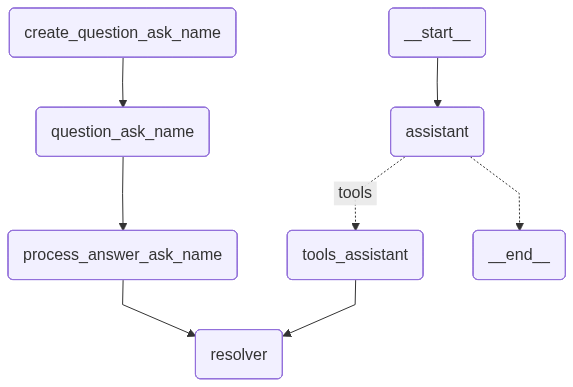

In [7]:
graph = get_assistant_graph()

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
async for step in graph.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Verify user information",
            }
        ],
    },
    config=config,
):
    display(step)

{'assistant': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_TK0HTAYD2mLXFDacY2127QWJ', 'function': {'arguments': '{}', 'name': 'verify_user_information'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 129, 'total_tokens': 213, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CG9avvZBYsit4o5x6bY4pl5fxOdsN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2e722a89-5429-4f8b-80eb-b0dfe1f98bc6-0', tool_calls=[{'name': 'verify_user_information', 'args': {}, 'id': 'call_TK0HTAYD2mLXFDacY2127QWJ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 129, 'output_tokens': 84, 'total_tokens': 213, 'input_token_de

{'tools_assistant': {'next': 'create_question_ask_name',
  'messages': [ToolMessage(content='Asking the user for their name.', name='verify_user_information', id='b1fd6360-789a-4ebe-b5b2-0fdf1e3d7eeb', tool_call_id='call_TK0HTAYD2mLXFDacY2127QWJ')]}}

{'resolver': {'next': None}}

{'create_question_ask_name': {'question': 'Please provide your full name (as used on your account) to verify your information.'}}

{'__interrupt__': (Interrupt(value={'question': 'Please provide your full name (as used on your account) to verify your information.'}, resumable=True, ns=['question_ask_name:be408538-e0e8-2869-a9d2-44956cc6dce7'], when='during'),)}

In [9]:
async for step in graph.astream(
    Command(resume={"answer": "Andres Javier"}), config=config
):
    display(step)

{'question_ask_name': {'question': 'Please provide your full name (as used on your account) to verify your information.',
  'answer': 'Andres Javier'}}

{'process_answer_ask_name': {'messages': [AIMessage(content='Please provide your full name (as used on your account) to verify your information.', additional_kwargs={}, response_metadata={}, id='cd895e40-71c4-4336-a291-f20eff2662bc'),
   HumanMessage(content='Andres Javier', additional_kwargs={}, response_metadata={}, id='8c43db28-445d-4aa7-bc56-c32e4a84dbcb')],
  'name': 'Andres Javier'}}

{'resolver': {'next': None}}

{'assistant': {'messages': [AIMessage(content='Thanks, Andres Javier. To complete verification, please provide:\n- Date of birth (MM/DD/YYYY) and\n- Last 4 digits of your account number.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 874, 'prompt_tokens': 193, 'total_tokens': 1067, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 832, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CG9b3to1tNhudWZ0awZNfZKd7ydLl', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--461070f7-bd34-4f1b-a784-1779fa6b1980-0', usage_metadata={'input_tokens': 193, 'output_tokens': 874, 'total_tokens': 1067, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 832}})]}}